# Technology

gdsfactory includes a default Technology in `gdsfactory.tech` that you can use as an inspiration to create your own.


## Layers

A GDS has different layers to describe the different fabrication process steps.

GDS layers have 2 integer numbers: GDSlayer, GDSpurpose

Klayout shows Layers with a color, style and transparency when showing GDS layouts.

In [1]:
import gdsfactory as gf

# gf.CONF.plotter = 'holoviews'

2022-04-29 12:46:14.152 | INFO     | gdsfactory.config:<module>:52 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 5.3.4


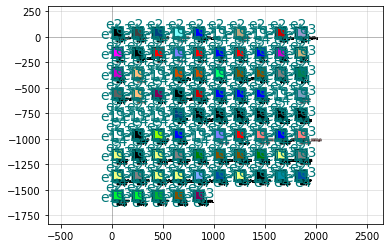

In [2]:
c = gf.layers.LAYER_SET.preview()
c.plot()

In [3]:
layer_wg = gf.LAYER.WG
print(layer_wg)

(1, 0)


### Remove layers

You can remove layers using the `remove_layers()` function.

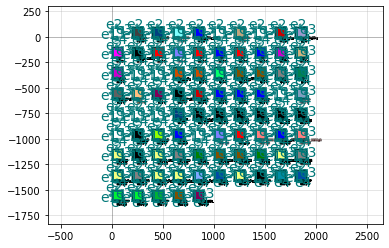

In [4]:
removed = c.remove_layers(layers=(gf.LAYER.WG, gf.LAYER.WGN))
removed.plot()

### Remap layers

You can remap (change the polygons from one layer to another layer) using the `remap_layer`, which will return a new `Component`

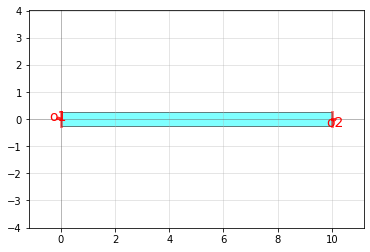

In [5]:
c = gf.components.straight(layer=(2, 0))
c.plot()

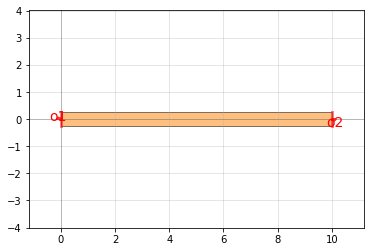

In [6]:
remap = c.remap_layers(layermap={(2, 0): gf.LAYER.WGN})
remap.plot()

### Extract layers

You can also extract layers using the `extract` function. This function returns a new flattened Component that contains the extracted layers.
A flat Component does not have references, and all the polygons are absorbed by the top cell.

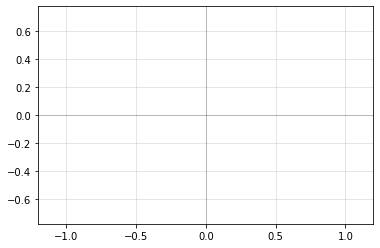

In [7]:
extract = c.extract(layers=(gf.LAYER.M1,))
extract.plot()

## Custom cross_section

You can create a `CrossSection` from scratch or you can customize the cross_section functions in `gf.cross_section`

In [8]:
import gdsfactory as gf

strip2 = gf.partial(gf.cross_section.strip, layer=(2, 0))

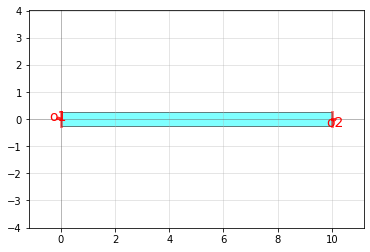

In [9]:
c = gf.components.straight(cross_section=strip2)
c.plot()

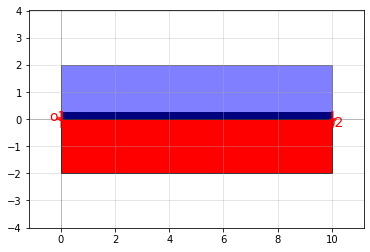

In [10]:
import gdsfactory as gf

pin = gf.partial(
    gf.cross_section.strip,
    sections=(
        gf.tech.Section(width=2, layer=gf.LAYER.N, offset=+1),
        gf.tech.Section(width=2, layer=gf.LAYER.P, offset=-1),
    ),
)
c = gf.components.straight(cross_section=pin)
c.plot()


How can you group all components to test them?

You can create a dict of functions and group them

```python

factory = dict(
    straight_heater_metal = gf.components.straight_heater_metal,
    bend = gf.components.bend_euler
)

```

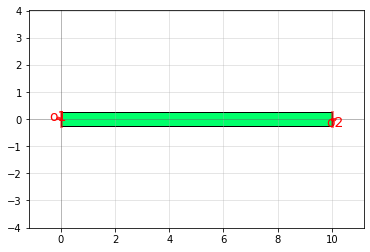

In [11]:
import gdsfactory as gf

c = gf.components.straight(layer=(41, 0))
c.plot()

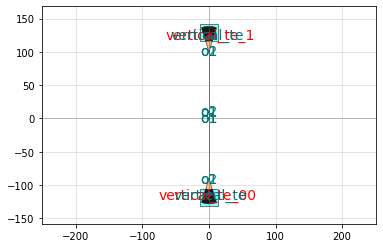

In [12]:
cross_section = gf.cross_section.nitride
wg = gf.components.straight(cross_section=cross_section)
gc = gf.components.grating_coupler_elliptical_te(layer=(34, 0), wg_width=1.0)
wg_gc = gf.routing.add_fiber_single(
    component=wg,
    grating_coupler=gc,
    cross_section=gf.cross_section.nitride,
    with_loopback=False,
)

# Loopback is an alinment structure where two gratings are connected back to back
wg_gc.plot()
wg_gc.show()

### FabA

Lets create some component factories for FabA

FabA only has one Metal layer available that is defined in GDS layer (30, 0)

The metal layer traces are 2um wide

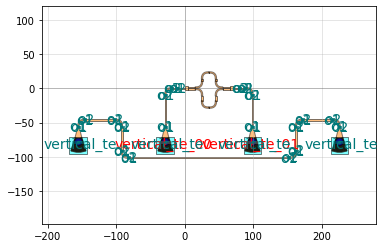

In [13]:
import gdsfactory as gf
from gdsfactory.cross_section import strip
from gdsfactory.tech import Layer


WIDTH = 2
LAYER = (34, 0)

xs_metal = gf.partial(strip, width=WIDTH, layer=LAYER)

straight = gf.partial(gf.components.straight, cross_section=xs_metal)
bend_euler = gf.partial(gf.components.bend_euler, cross_section=xs_metal)
mmi1x2 = gf.partial(
    gf.components.mmi1x2,
    cross_section=xs_metal,
    width=WIDTH,
    width_taper=WIDTH,
    width_mmi=3 * WIDTH,
)
mzi = gf.partial(gf.components.mzi, cross_section=xs_metal, splitter=mmi1x2)
gc = gf.partial(
    gf.components.grating_coupler_elliptical_te, layer=LAYER, wg_width=WIDTH
)


c = mzi()
c_gc = gf.routing.add_fiber_array(
    component=c, grating_coupler=gc, cross_section=xs_metal
)
c_gc.plot()

you can also add a cell `decorator` in case you want to add pins or device recognition layers

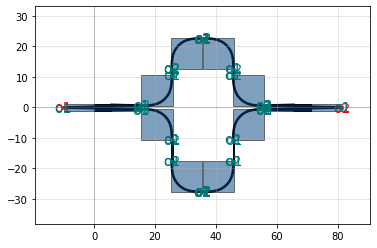

In [14]:
import gdsfactory as gf
from gdsfactory.add_pins import add_outline, add_pins
from gdsfactory.cross_section import strip
from gdsfactory.difftest import difftest

WIDTH = 2
LAYER = (34, 0)

fab_a_metal = gf.partial(strip, width=WIDTH, layer=LAYER)


def test_waveguide():
    c = gf.components.straight(cross_section=fab_a_metal)
    difftest(c)


def decorator(component) -> None:
    """Fab specific functions over a component."""
    add_pins(component)
    add_outline(component)


mmi2x2 = gf.partial(gf.components.mmi2x2, decorator=decorator)
mmi1x2 = gf.partial(gf.components.mmi1x2, decorator=decorator)
bend_euler = gf.partial(gf.components.bend_euler, decorator=decorator)
straight = gf.partial(gf.components.straight, decorator=decorator)
mzi = gf.partial(gf.components.mzi, splitter=mmi1x2, bend=bend_euler, straight=straight)

mzi10 = mzi(delta_length=10)
mzi10.plot()

### FabB

FabB has photonic waveguides that require many cladding layers to avoid dopants

Lets say that the waveguides are defined in layer (2, 0) and are 0.3um wide

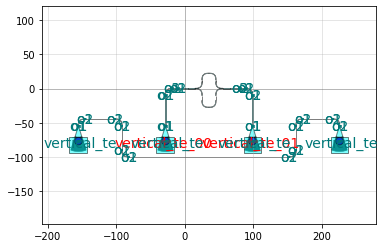

In [15]:
import gdsfactory as gf
from gdsfactory.cross_section import strip
from gdsfactory.difftest import difftest

WIDTH = 0.3
LAYER = (2, 0)


fab_b_metal = gf.partial(
    strip,
    width=WIDTH,
    layer=LAYER,
)

straight = gf.partial(gf.components.straight, cross_section=fab_b_metal)
bend_euler = gf.partial(gf.components.bend_euler, cross_section=fab_b_metal)
mmi1x2 = gf.partial(
    gf.components.mmi1x2,
    cross_section=fab_b_metal,
    width=WIDTH,
    width_taper=WIDTH,
    width_mmi=4 * WIDTH,
)
mzi = gf.partial(gf.components.mzi, cross_section=fab_b_metal, splitter=mmi1x2)
gc = gf.partial(
    gf.components.grating_coupler_elliptical_te, layer=LAYER, wg_width=WIDTH
)


def test_waveguide():
    c = gf.components.straight(cross_section=fab_b_metal)
    difftest(c)


c = mzi()
wg_gc = gf.routing.add_fiber_array(
    component=c, grating_coupler=gc, cross_section=fab_b_metal
)
wg_gc.plot()

### FabC

Lets assume that fab C has both Silicon and Silicon Nitride components, and you need different waveguide widths for C and O band.

Lets asume that O band nitride waveguide width is 0.9 and Cband Nitride waveguide width is 1um, and for 0.4um for Silicon O band and 0.5um for silicon Cband.

Lets also that this foundry has an LVS flow where all components have optical pins defined in layer (100, 0)

In [16]:
from typing import Callable, Dict, Optional, Tuple
import pydantic.dataclasses as dataclasses

import gdsfactory as gf
from gdsfactory.add_pins import add_pin_rectangle_inside
from gdsfactory.component import Component, ComponentReference
from gdsfactory.cross_section import strip
from gdsfactory.tech import LayerLevel, LayerStack, Tech
from gdsfactory.types import Layer


@dataclasses.dataclass(frozen=True)
class LayerMap:
    WG: Layer = (10, 1)
    WG_CLAD: Layer = (10, 2)
    WGN: Layer = (34, 0)
    WGN_CLAD: Layer = (36, 0)
    PIN: Layer = (100, 0)


LAYER = LayerMap()
WIDTH_NITRIDE_OBAND = 0.9
WIDTH_NITRIDE_CBAND = 1.0
PORT_TYPE_TO_LAYER = dict(optical=(100, 0))


def get_layer_stack_fab_c(thickness: float = 350.0) -> LayerStack:
    """Returns generic LayerStack"""
    return LayerStack(
        layers=dict(
            core=LayerLevel(
                layer=(34, 0),
                thickness=350.0,
                zmin=220.0 + 100.0,
            ),
            clad=LayerLevel(layer=(36, 0)),
        )
    )


def add_pins(
    component: Component,
    function: Callable = add_pin_rectangle_inside,
    pin_length: float = 0.5,
    port_layer: Layer = LAYER.PIN,
    **kwargs,
) -> Component:
    """Add Pin port markers.

    Args:
        component: to add ports
        function:
        pin_length:
        port_layer:
        function: kwargs

    """
    for p in component.ports.values():
        function(
            component=component,
            port=p,
            layer=port_layer,
            layer_label=port_layer,
            pin_length=pin_length,
            **kwargs,
        )
    return component


# cross_sections

bbox_layers = [LAYER.WGN_CLAD]
bbox_offsets = [3]

fabc_nitride_cband = gf.partial(
    strip,
    width=WIDTH_NITRIDE_CBAND,
    layer=LAYER.WGN,
    bbox_layers=bbox_layers,
    bbox_offsets=bbox_offsets,
)
fabc_nitride_oband = gf.partial(
    strip,
    width=WIDTH_NITRIDE_OBAND,
    layer=LAYER.WGN,
    bbox_layers=bbox_layers,
    bbox_offsets=bbox_offsets,
)


# LEAF COMPONENTS have pins

mmi1x2_nitride_c = gf.partial(
    gf.components.mmi1x2,
    width=WIDTH_NITRIDE_CBAND,
    cross_section=fabc_nitride_cband,
    decorator=add_pins,
)
mmi1x2_nitride_o = gf.partial(
    gf.components.mmi1x2,
    width=WIDTH_NITRIDE_OBAND,
    cross_section=fabc_nitride_oband,
    decorator=add_pins,
)
bend_euler_c = gf.partial(
    gf.components.bend_euler, cross_section=fabc_nitride_cband, decorator=add_pins
)
straight_c = gf.partial(
    gf.components.straight, cross_section=fabc_nitride_cband, decorator=add_pins
)
bend_euler_o = gf.partial(
    gf.components.bend_euler, cross_section=fabc_nitride_oband, decorator=add_pins
)
straight_o = gf.partial(
    gf.components.straight, cross_section=fabc_nitride_oband, decorator=add_pins
)

gc_nitride_c = gf.partial(
    gf.components.grating_coupler_elliptical_te,
    grating_line_width=0.6,
    wg_width=WIDTH_NITRIDE_CBAND,
    layer=LAYER.WGN,
    decorator=add_pins,
)

# HIERARCHICAL COMPONENTS made of leaf components

mzi_nitride_c = gf.partial(
    gf.components.mzi,
    cross_section=fabc_nitride_cband,
    splitter=mmi1x2_nitride_c,
    decorator=add_pins,
    straight=straight_c,
    bend=bend_euler_c,
)
mzi_nitride_o = gf.partial(
    gf.components.mzi,
    cross_section=fabc_nitride_oband,
    splitter=mmi1x2_nitride_o,
    decorator=add_pins,
    straight=straight_o,
    bend=bend_euler_o,
)

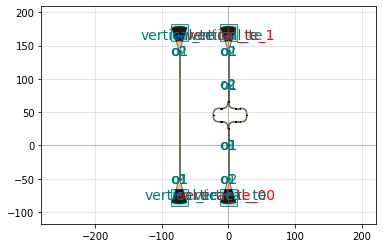

In [17]:
mzi = mzi_nitride_c()
mzi_gc = gf.routing.add_fiber_single(
    component=mzi,
    grating_coupler=gc_nitride_c,
    cross_section=fabc_nitride_cband,
    optical_routing_type=1,
    straight=straight_c,
    bend=bend_euler_c,
)
mzi_gc.plot()

In [18]:
ls = get_layer_stack_fab_c()

In [19]:
ls.to_dict()

{'core': {'layer': (34, 0),
  'thickness': 350.0,
  'zmin': 320.0,
  'material': None,
  'sidewall_angle': 0},
 'clad': {'layer': (36, 0),
  'thickness': None,
  'zmin': None,
  'material': None,
  'sidewall_angle': 0}}

## 3D rendering

You can also render components in 3D.

You will need to define two things:

1. LayerStack: for each layer contains thickness of each material and z position
2. LayerSet: for each layer contains colors (this file is the same that Klayout uses). You can load it with `gf.layers.load_lyp()`

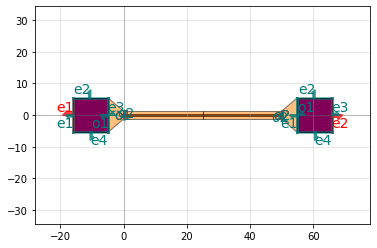

In [20]:
heater = gf.components.straight_heater_metal(length=50)
heater.plot()

In [21]:
scene = gf.export.to_3d(component=heater, layer_set=gf.layers.LAYER_SET)
scene.show()

/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
